In [1]:
import skimage
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from scipy.optimize import curve_fit
from matplotlib import rcParams
from statsmodels.stats.weightstats import ttest_ind
from statannotations.Annotator import Annotator
rcParams['figure.dpi'] = 250
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 20

In [36]:
class Plate():

    def __init__(self, data_dir, analysis_name):
        self.data_dir = data_dir
        self.analysis_name = analysis_name
        self._load_data()
        self._load_platemap()

    def _load_data(self):
            
        self.image_data = pd.read_csv(self.data_dir / 
                                self.analysis_name /
                                # (self.analysis_name + '_Image.csv'))
                                ('2023-04-03_cellpose_tdp-43' + '_Image.csv'))
        self.soma_data = pd.read_csv(self.data_dir / 
                                self.analysis_name /
                                # (self.analysis_name + '_cytoplasm_outlines.csv'))
                                ('2023-04-03_cellpose_tdp-43' + '_cytoplasm_outlines.csv'))
        self.nuclei_data = pd.read_csv(self.data_dir / 
                                self.analysis_name /
                                # (self.analysis_name + '_nuclei.csv'))
                                ('2023-04-03_cellpose_tdp-43' + '_nuclei.csv'))
    
    def _load_platemap(self):
        self.platemap = pd.read_csv(self.data_dir / 'platemap.csv') 
    
    # def reindex_nuclei(self):
    #     nucleus_selection = []
    #     for img_number in self.nuclei_data['ImageNumber'].unique():

    #         nd = self.nuclei_data.query('ImageNumber==@img_number')
    #         sd = self.soma_data.query('ImageNumber==@img_number')

    #         for i_soma, sd_row in sd.iterrows():
    #             soma_bb = get_bounding_box(sd_row)
            
    #             ion_list = []
    #             for i_nucleus, nd_row in nd.iterrows():
    #                 nucleus_bb = get_bounding_box(nd_row)

    #                 ion_list.append(get_ion(soma_bb, nucleus_bb))

    #             best_nucleus = np.array(ion_list).argmax()
    #             nucleus_selection.append(nd.index[best_nucleus])

    #     self.nuclei_data = self.nuclei_data.loc[nucleus_selection]

    def reindex_nuclei(self):
        self.nuclei_data['ParentImgObj'] = (
            self.nuclei_data['ImageNumber'].astype(str) + '-' +  \
            self.nuclei_data['Parent_cytoplasm_outlines_pre_masked'].astype(str)
        )
        # nuclei_data['Parent_nuclei_pre_mask'].astype(str)
        self.soma_data['ImgObj'] = (
            self.soma_data['ImageNumber'].astype(str) + '-' + \
            self.soma_data['ObjectNumber'].astype(str)
        )
        self.soma_data.index = self.soma_data['ImgObj']
        self.soma_data = self.soma_data.loc[self.nuclei_data['ParentImgObj']]
        self.soma_data.index = range(self.soma_data.shape[0])

In [3]:
def calculate_ratio(plate, measurement):

    ratio_data = pd.DataFrame(index = plate.soma_data.index)

    # Set filename and well position
    ratio_data['FileName_TDP43'] = plate.soma_data['FileName_TDP43']
    ratio_data['well_position'] = ratio_data['FileName_TDP43'].apply(
        lambda fname : chr(int(fname[1:3])+64) + fname[4:6]
    )
    ratio_data['row'] = ratio_data['FileName_TDP43'].apply(
    lambda fname : int(fname[1:3])
    )
    ratio_data['col'] = ratio_data['FileName_TDP43'].apply(
        lambda fname : int(fname[4:6])
    )

    # Add (nucleus) object number
    ratio_data['object_number'] = plate.nuclei_data['ObjectNumber']

    # Get mean TDP43 in nucleus
    ratio_data['TDP43_nucleus'] = (
        plate.nuclei_data[measurement] / 
        1
        # plate.nuclei_data['AreaShape_Area']
        )

    # Get mean TDP43 in cytoplasm, subtracting out nucleus first
    ratio_data['TDP43_cytoplasm'] = (
        (plate.soma_data[measurement]) /
        1  
        # plate.soma_data['AreaShape_Area']  
        # (plate.soma_data['AreaShape_Area'] - 
        # plate.nuclei_data['AreaShape_Area'])
    )

    # Get ratio of cytoplasm / nucleus
    ratio_data['TDP43_ratio'] = (
        ratio_data['TDP43_cytoplasm'] / 
        ratio_data['TDP43_nucleus']
        # ratio_data['TDP43_nucleus'] / 
        # ratio_data['TDP43_cytoplasm']
    )
    return ratio_data


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_UNC13A vs. 2_NT: t-test independent samples with Bonferroni correction, P_val:6.468e-03 t=-3.317e+00
0_UNC13A vs. 0_NT: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=-6.508e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_C9ORF72 vs. 2_NT: t-test independent samples with Bonferroni correction, P_val:9.087e-02 t=2.486e+00
0_C9ORF72 vs. 0_NT: t-test independent samples with Bonferroni correction, P_val:5.167e-01 t=1.788e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_SCFD1 vs. 2_NT: t-test independent samples 

Text(0.5, 0.98, 'C/N - mean intensity - cell-level - 2023-04-03_CellPose')

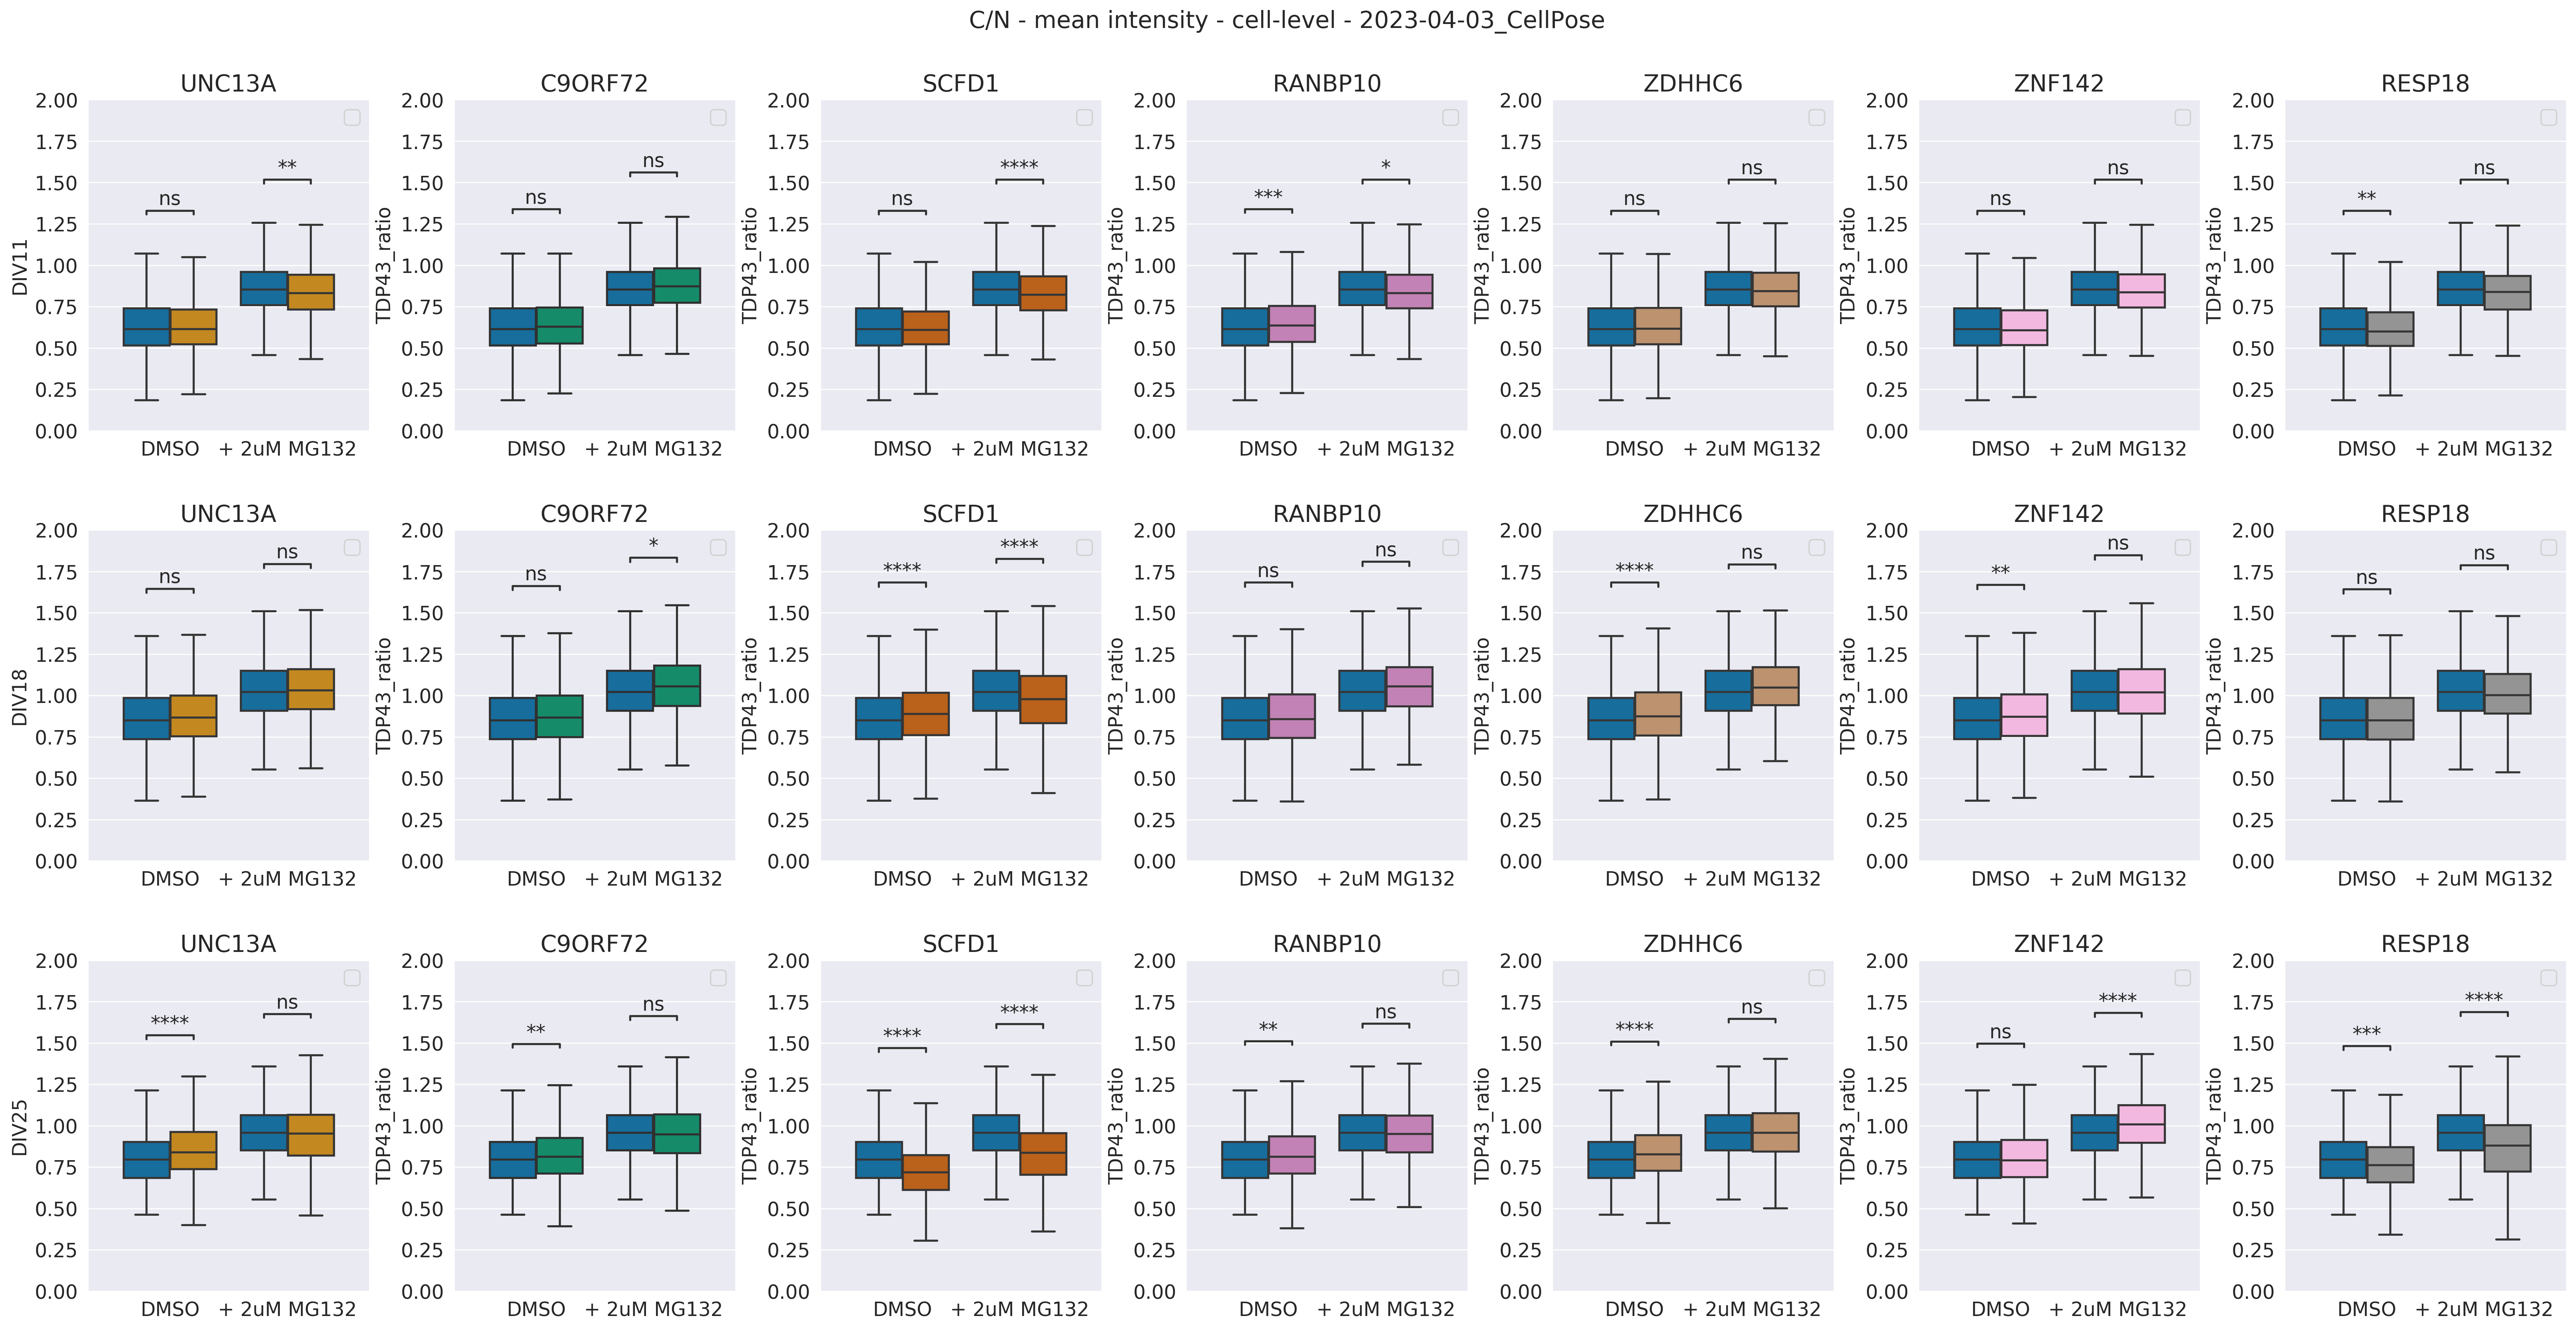

In [74]:
dirs = [Path('/lab/processed-data/ALS0006_NGN2_DIV11_KOv1_MG132/DIV11__2023-02-15T11_31_26-Measurement 1'),
    Path('/lab/processed-data/ALS0006_NGN2_DIV18_KOv1_MG132/DIV18__2023-02-24T08_47_12-Measurement 1'),
    Path('/lab/processed-data/ALS0006_KO01_TDP43_20X/ALS0006_KO01_TDP43_20X_01__2023-03-08T11_11_56-Measurement 1/')]
analysis_name = '2023-04-03_cellpose_tdp-43'
measurement = 'Intensity_IntegratedIntensity_TDP43_corrected'
measurement = 'Intensity_MeanIntensity_TDP43_corrected'
# measurement = 'Location_Center_X'
neg_con = 'NT'
concentration = "2"

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (32, 15)
plt.rcParams['font.size'] = 14
NT_color = sns.color_palette('colorblind')[0]
ylims = [[0.3, 1.6], [0.5, 1.8], [0.4, 2]]
# crispr_mutants = ratio_data.query('crispr not in["empty", @neg_con]')['crispr'].unique()
crispr_mutants = ['UNC13A', 'C9ORF72', 'SCFD1', 'RANBP10', 'ZDHHC6', 'ZNF142',
       'RESP18']
fig, axs = plt.subplots(3, len(crispr_mutants))

for i_exp, data_dir in enumerate(dirs):
    plate = Plate(data_dir, analysis_name)
    plate.reindex_nuclei()
    ratio_data = calculate_ratio(plate, measurement)
    ratio_data = ratio_data.merge(plate.platemap, on='well_position')
    # ratio_data_max = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).max()
    # ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()
    # ratio_data = ratio_data.groupby(['well_position', 'crispr', 'treatment', 'concentration']).mean()
    # ratio_data_max = ratio_data_max.reset_index()
    # ratio_data = ratio_data.reset_index()
    # ratio_data = ratio_data.drop(ratio_data_max.index[ratio_data_max['object_number'] < 10])
    # ratio_data = ratio_data.drop(ratio_data.index[ratio_data['TDP43_ratio'] > 2])

    # pairs = [[(('0', 'NT'), ('0', crispr)), (('2', 'NT'), ('2', crispr))][0] for crispr in crispr_mutants]
    for i_crispr, crispr in enumerate(crispr_mutants):

        data = ratio_data.query('crispr in [@neg_con, @crispr] and concentration in ["0", @concentration]')
        hue = 'crispr'
        x = 'concentration'
        y = 'TDP43_ratio'
        # y = 'TDP43_cytoplasm'
        ax = axs[i_exp,i_crispr]
        crispr_color = sns.color_palette('colorblind')[i_crispr+1]
        hue_order = ['NT', crispr]
        sns.boxplot(ax=ax,data=data, x=x, y=y, hue=hue, hue_order=hue_order, palette=[NT_color, crispr_color], showfliers=False)
        # sns.stripplot(ax=ax,data=data, x=x, y=y, hue=hue,  hue_order=hue_order, dodge=True, linewidth=2, size=10, palette=[NT_color, crispr_color], alpha=0.7)
        ax.set_xticklabels(['DMSO', '+ ' + concentration + 'uM MG132'])
        ax.set_xlabel('')
        ax.legend([])
        ax.set_title(crispr)

        pairs = [(('0', neg_con), ('0', crispr)), ((concentration, neg_con), (concentration, crispr))]
        annot = Annotator(ax, pairs, data=data, x=x, y=y, hue=hue)
        annot.configure(test='t-test_ind', text_format='star',  comparisons_correction='bonferroni')
        annot.apply_test(num_comparisons=len(crispr_mutants))
        ax, test_results = annot.annotate(line_offset_to_group=0.2)
        # ax.set_ylim(ylims[i_exp])
        ax.set_ylim([0, 2])

plt.subplots_adjust(wspace=0.3, hspace=0.3, top=0.92)
axs[0,0].set_ylabel('DIV11')
axs[1,0].set_ylabel('DIV18')
axs[2,0].set_ylabel('DIV25')
plt.suptitle('C/N - mean intensity - cell-level - 2023-04-03_CellPose')

0.25_Non-Targeting vs. 0.25_CPEB1: t-test independent samples, P_val:6.369e-14 t=7.522e+00
0_Non-Targeting vs. 0_CPEB1: t-test independent samples, P_val:5.789e-204 t=-3.095e+01
0.25_Non-Targeting vs. 0.25_CSNK2B: t-test independent samples, P_val:5.383e-06 t=4.554e+00
0_Non-Targeting vs. 0_CSNK2B: t-test independent samples, P_val:7.710e-197 t=-3.035e+01
0.25_Non-Targeting vs. 0.25_DDX39B: t-test independent samples, P_val:2.236e-13 t=7.356e+00
0_Non-Targeting vs. 0_DDX39B: t-test independent samples, P_val:4.988e-155 t=-2.684e+01
0.25_Non-Targeting vs. 0.25_DECR2: t-test independent samples, P_val:5.965e-02 t=1.884e+00
0_Non-Targeting vs. 0_DECR2: t-test independent samples, P_val:1.228e-303 t=-3.816e+01
0.25_Non-Targeting vs. 0.25_DHRS11: t-test independent samples, P_val:1.825e-10 t=6.390e+00
0_Non-Targeting vs. 0_DHRS11: t-test independent samples, P_val:6.006e-138 t=-2.527e+01
0.25_Non-Targeting vs. 0.25_FGFRL1: t-test independent samples, P_val:7.573e-06 t=4.482e+00
0_Non-Target

Text(0.5, 0.98, 'TDP43_ALS0013_DIV11_KO_MG132 - DIV11 v1__2023-03-15T09_33_32-Measurement 1\nC/N - mean intensity - cell-level - 2023-04-03_CellPose')

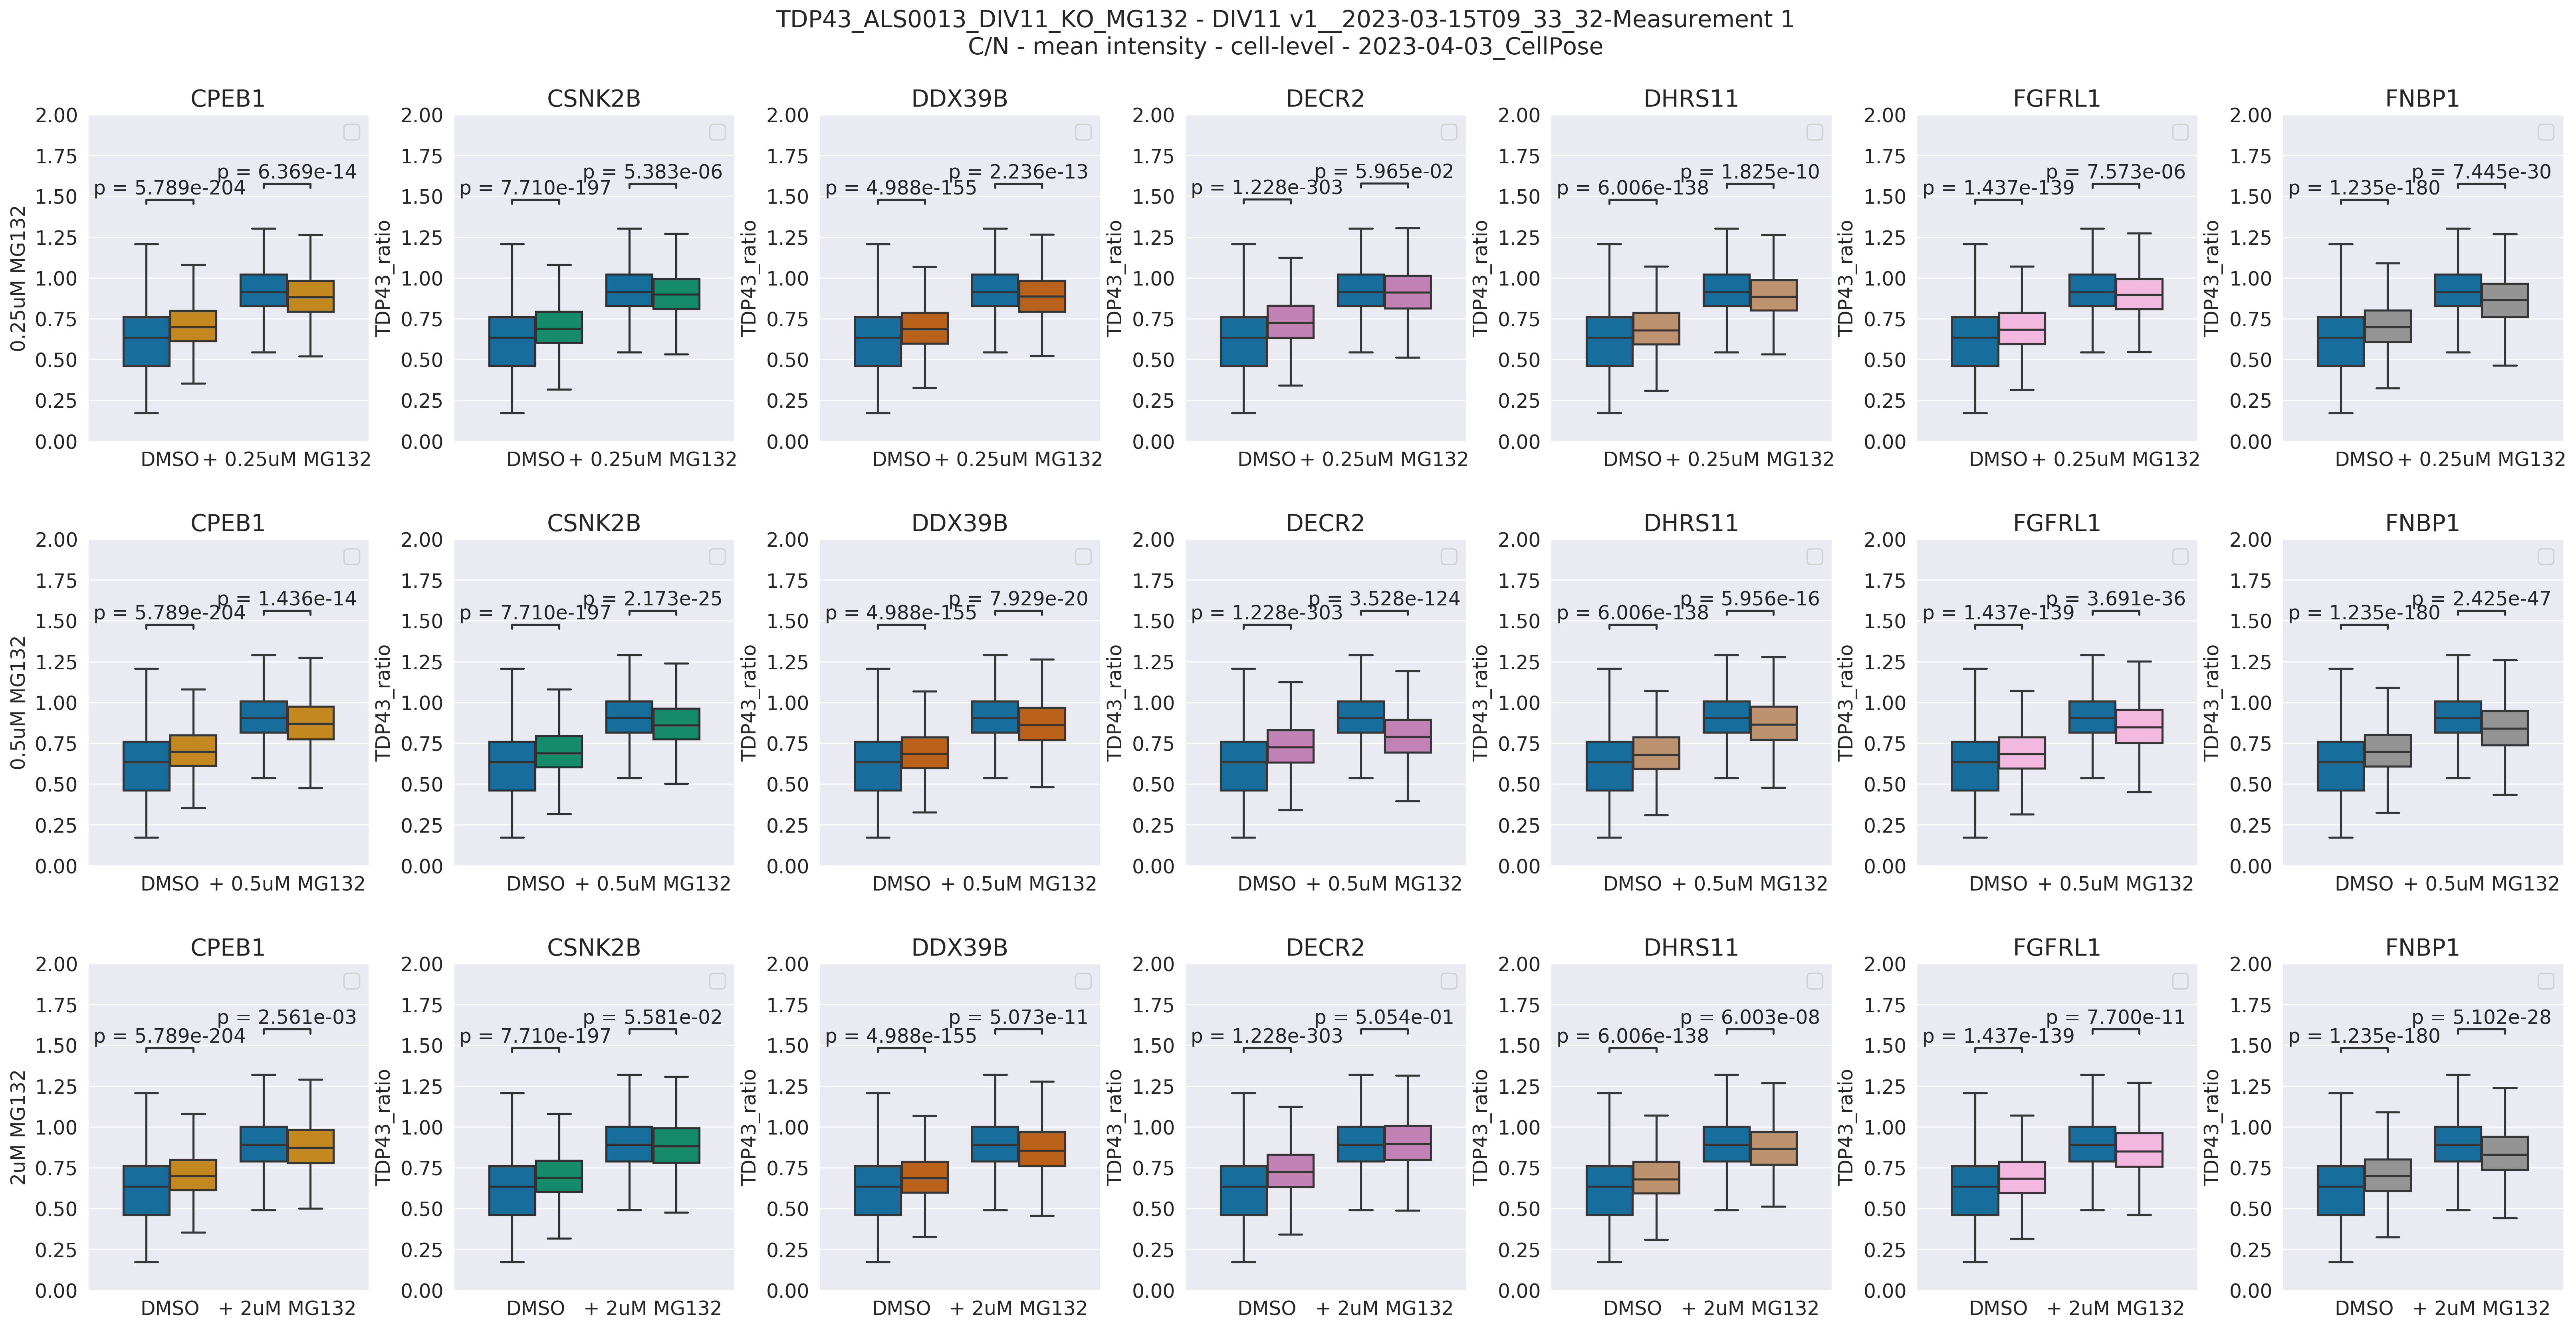

In [13]:
dirs = [Path('/lab/processed-data/TDP43_ALS0009_DIV18_KO_MG132/TDP43_ALS0009_KO1_DIV18_v1__2023-03-14T10_55_23-Measurement 1'),
        Path('/lab/processed-data/TDP43_ALS0009_DIV18_KO_MG132/ALS0009_DIV18_20230320_AH__2023-03-20T11_16_36-Measurement 1'),
    Path('/lab/processed-data/TDP43_ALS0013_DIV11_KO_MG132/DIV11 v1__2023-03-15T09_33_32-Measurement 1/'),
    Path('/lab/processed-data/TDP43_ALS0014_NGN2_KO1_20x_DIV11_2023-03-31/DIV11 NGN2 488TDP43 594MAP2__2023-03-31T16_47_11-Measurement 1')]
# dirs = [Path('/lab/processed-data/ALS0006_NGN2_DIV11_KOv1_MG132/DIV11__2023-02-15T11_31_26-Measurement 1'),
#     Path('/lab/processed-data/ALS0006_NGN2_DIV18_KOv1_MG132/DIV18__2023-02-24T08_47_12-Measurement 1'),
#     Path('/lab/processed-data/ALS0006_KO01_TDP43_20X/ALS0006_KO01_TDP43_20X_01__2023-03-08T11_11_56-Measurement 1/')]
analysis_name = '2023-04-03_cellpose_tdp-43'
measurement = 'Intensity_MeanIntensity_TDP43_corrected'
neg_con = 'Non-Targeting'
# neg_con = 'NT'
concentrations = ['0.25', '0.5', '2']

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (32, 15)
plt.rcParams['font.size'] = 14
NT_color = sns.color_palette('colorblind')[0]
ylims = [[0.3, 1.6], [0.5, 1.8], [0.4, 2]]
# crispr_mutants = ['UNC13A', 'C9ORF72', 'SCFD1', 'RANBP10', 'ZDHHC6', 'ZNF142',
    #    'RESP18']

data_dir = dirs[2]
plate = Plate(data_dir, analysis_name)
plate.reindex_nuclei()
ratio_data = calculate_ratio(plate, measurement)
ratio_data = ratio_data.merge(plate.platemap, on='well_position')
# ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()
# ratio_data = ratio_data.groupby(['well_position', 'crispr', 'treatment', 'concentration']).mean()
# ratio_data = ratio_data.reset_index()
# ratio_data = ratio_data.drop(ratio_data.index[ratio_data['TDP43_ratio'] > 2])
crispr_mutants = ratio_data.query('crispr not in["empty", "No Nucleofection", @neg_con]')['crispr'].unique()
fig, axs = plt.subplots(3, len(crispr_mutants))

# pairs = [[(('0', 'NT'), ('0', crispr)), (('2', 'NT'), ('2', crispr))][0] for crispr in crispr_mutants]
for i_exp, concentration in enumerate(concentrations):
    for i_crispr, crispr in enumerate(crispr_mutants):

        data = ratio_data.query('crispr in [@neg_con, @crispr] and concentration in ["0", @concentration]')
        hue = 'crispr'
        x = 'concentration'
        y = 'TDP43_ratio'
        ax = axs[i_exp,i_crispr]
        crispr_color = sns.color_palette('colorblind')[i_crispr+1]
        hue_order = [neg_con, crispr]
        sns.boxplot(ax=ax,data=data, x=x, y=y, hue=hue, hue_order=hue_order, palette=[NT_color, crispr_color], showfliers=False)
        # sns.stripplot(ax=ax,data=data, x=x, y=y, hue=hue,  hue_order=hue_order, dodge=True, linewidth=2, size=10, palette=[NT_color, crispr_color], alpha=0.7)
        ax.set_xticklabels(['DMSO', '+ ' + concentration + 'uM MG132'])
        ax.set_xlabel('')
        ax.legend([])
        ax.set_title(crispr)

        pairs = [(('0', neg_con), ('0', crispr)), ((concentration, neg_con), (concentration, crispr))]
        annot = Annotator(ax, pairs, data=data, x=x, y=y, hue=hue)
        # annot.configure(test='t-test_ind', text_format='simple',  show_test_name=False, comparisons_correction='bonferroni')
        annot.configure(test='t-test_ind', text_format='full',  show_test_name=False)
        # annot.apply_test(num_comparisons=len(crispr_mutants))
        annot.apply_test()
        ax, test_results = annot.annotate(line_offset_to_group=0.2)
        ax.set_ylim([0, 2])

    axs[i_exp,0].set_ylabel(concentration + 'uM MG132')
plt.subplots_adjust(wspace=0.3, hspace=0.3, top=0.91)
plt.suptitle(data_dir.parents[0].name + ' - ' + data_dir.name + '\nC/N - mean intensity - cell-level - 2023-04-03_CellPose' )

0_Non-Targeting vs. 0_CPEB1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.196e-23 U_stat=3.282e+07
0.25_Non-Targeting vs. 0.25_CPEB1: Mann-Whitney-Wilcoxon test two-sided, P_val:3.106e-28 U_stat=6.211e+06
0.5_Non-Targeting vs. 0.5_CPEB1: Mann-Whitney-Wilcoxon test two-sided, P_val:7.843e-26 U_stat=5.836e+06
2_Non-Targeting vs. 2_CPEB1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.449e-10 U_stat=5.152e+06
0_Non-Targeting vs. 0_CSNK2B: Mann-Whitney-Wilcoxon test two-sided, P_val:1.066e-50 U_stat=3.974e+07
0.25_Non-Targeting vs. 0.25_CSNK2B: Mann-Whitney-Wilcoxon test two-sided, P_val:1.918e-20 U_stat=6.389e+06
0.5_Non-Targeting vs. 0.5_CSNK2B: Mann-Whitney-Wilcoxon test two-sided, P_val:7.492e-52 U_stat=6.073e+06
2_Non-Targeting vs. 2_CSNK2B: Mann-Whitney-Wilcoxon test two-sided, P_val:5.820e-08 U_stat=5.114e+06
0.5_Non-Targeting vs. 0.5_DDX39B: Mann-Whitney-Wilcoxon test two-sided, P_val:3.705e-29 U_stat=5.469e+06
2_Non-Targeting vs. 2_DDX39B: Mann-Whitney-Wilcoxon test two-sided, P_v

Text(0.5, 0.98, 'TDP43_ALS0013_DIV11_KO_MG132 - DIV11 v1__2023-03-15T09_33_32-Measurement 1\nC/N - mean intensity - cell-level - 2023-04-03_CellPose')

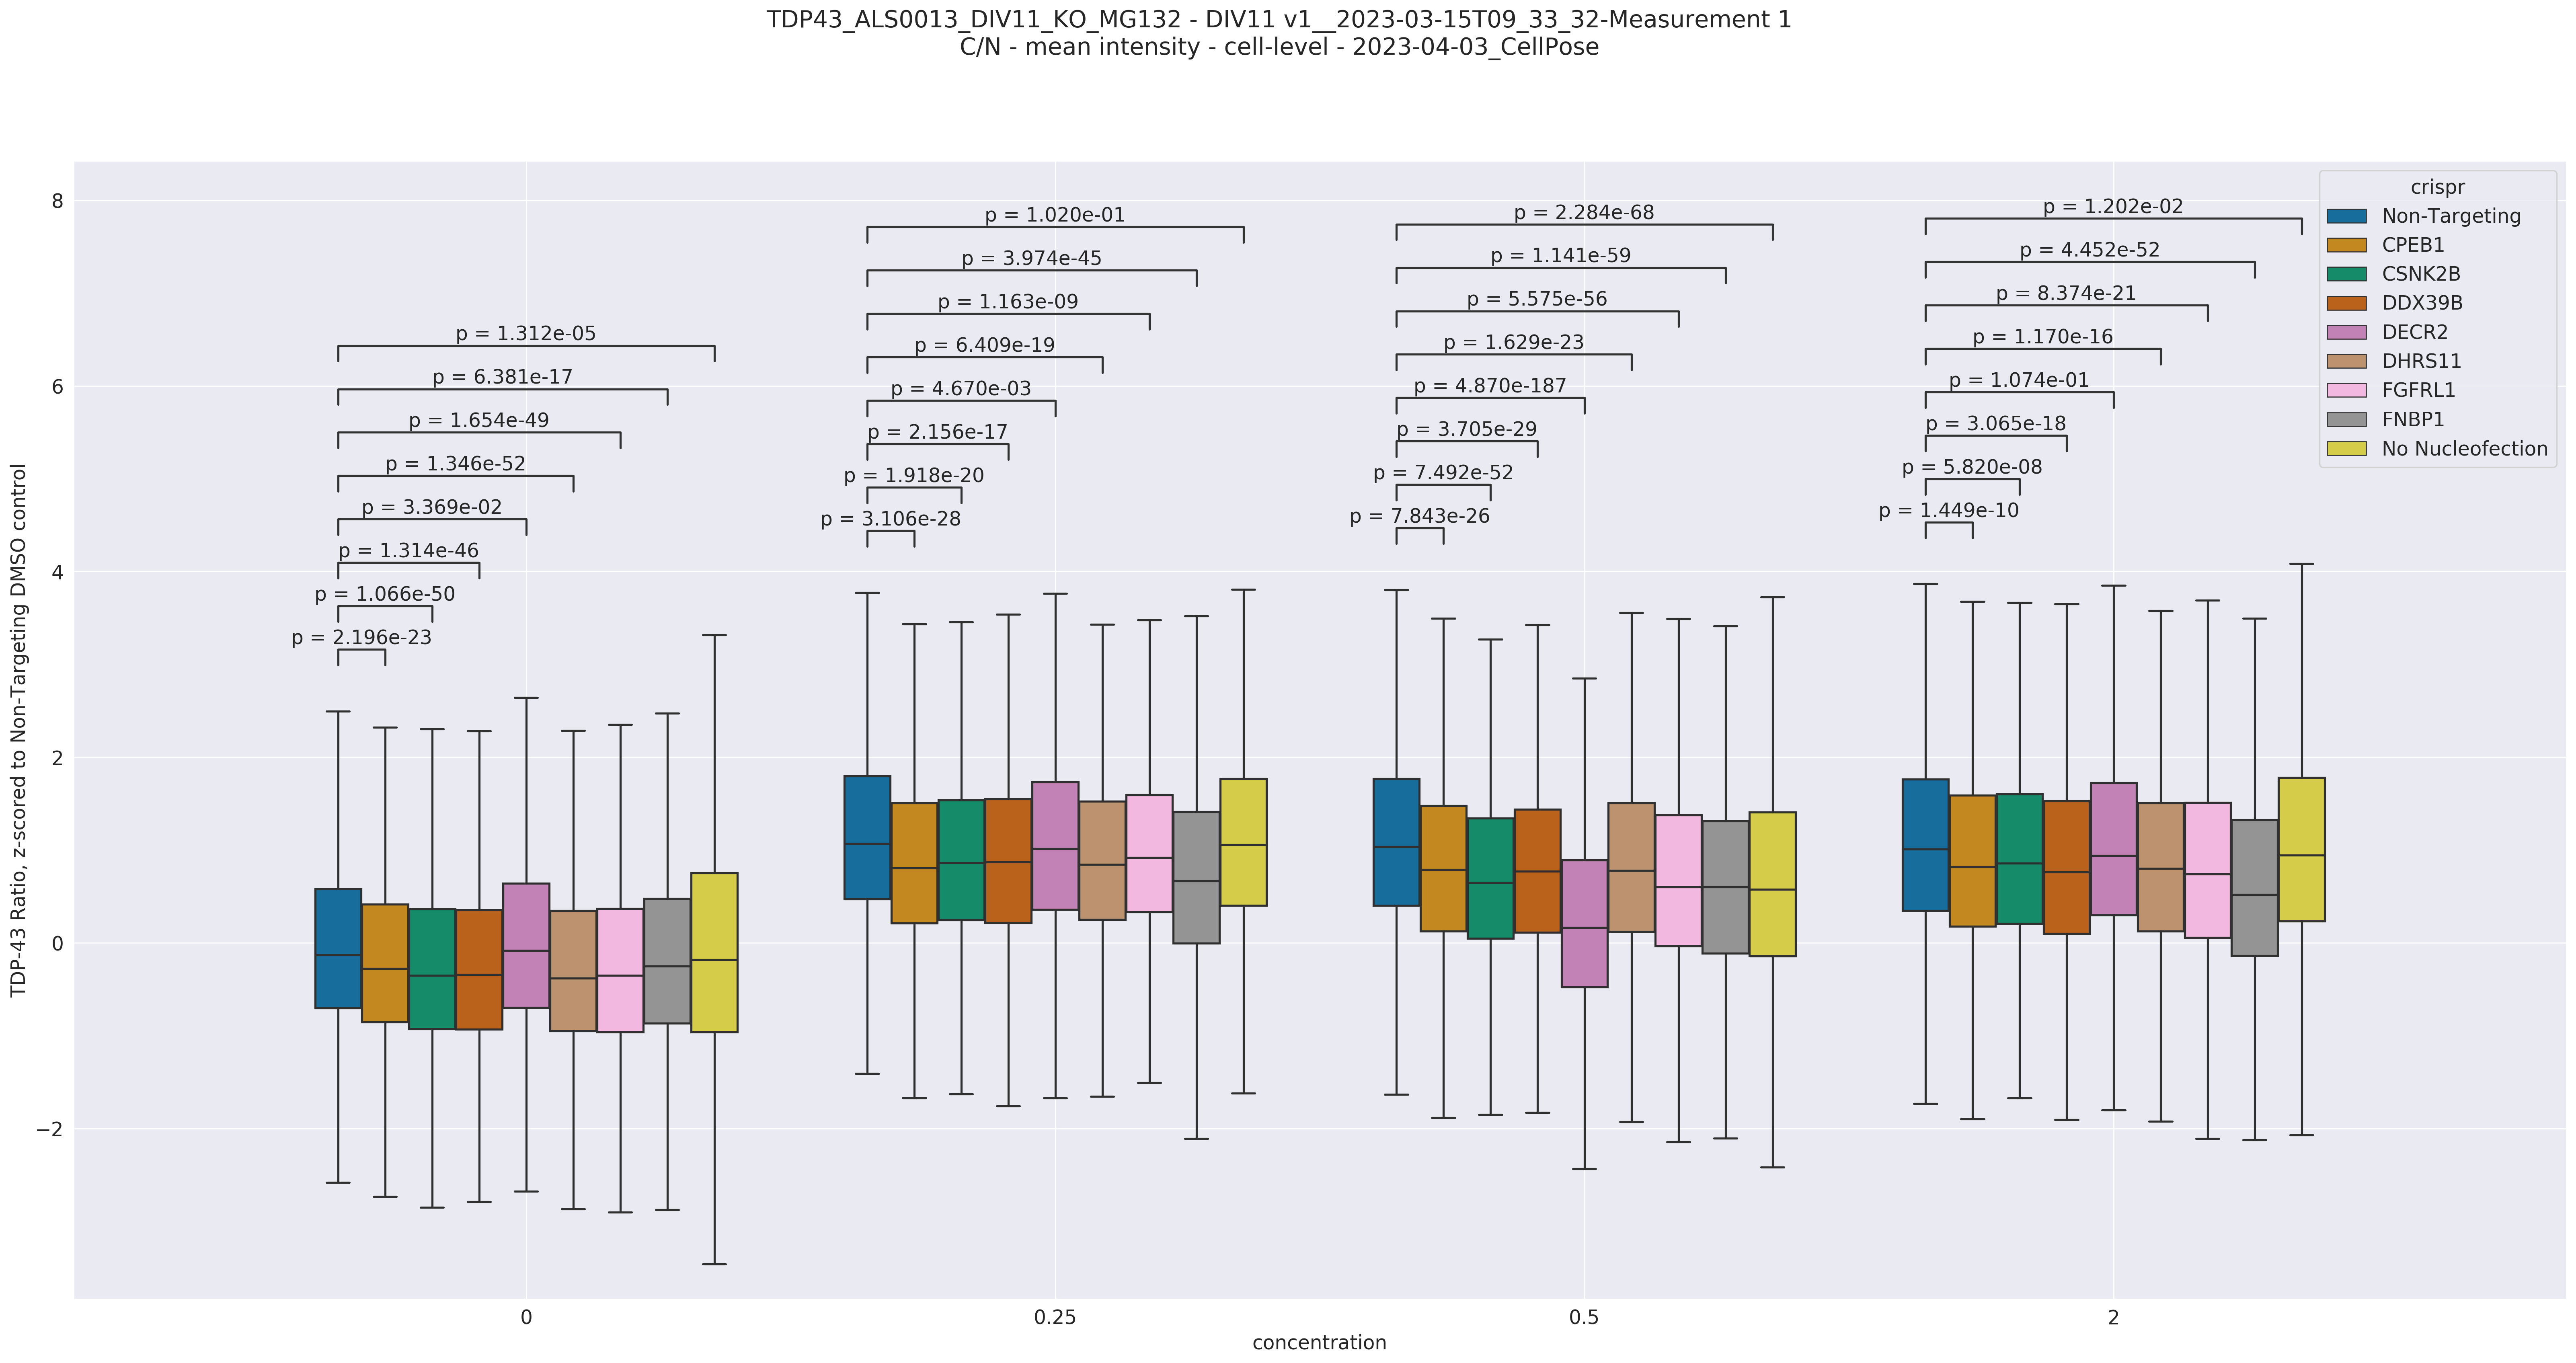

In [42]:
dirs = [Path('/lab/processed-data/TDP43_ALS0009_DIV18_KO_MG132/TDP43_ALS0009_KO1_DIV18_v1__2023-03-14T10_55_23-Measurement 1'),
        Path('/lab/processed-data/TDP43_ALS0009_DIV18_KO_MG132/ALS0009_DIV18_20230320_AH__2023-03-20T11_16_36-Measurement 1'),
    Path('/lab/processed-data/TDP43_ALS0013_DIV11_KO_MG132/DIV11 v1__2023-03-15T09_33_32-Measurement 1/'),
    Path('/lab/processed-data/TDP43_ALS0014_NGN2_KO1_20x_DIV11_2023-03-31/DIV11 NGN2 488TDP43 594MAP2__2023-03-31T16_47_11-Measurement 1')]
# dirs = [Path('/lab/processed-data/ALS0006_NGN2_DIV11_KOv1_MG132/DIV11__2023-02-15T11_31_26-Measurement 1'),
#     Path('/lab/processed-data/ALS0006_NGN2_DIV18_KOv1_MG132/DIV18__2023-02-24T08_47_12-Measurement 1'),
#     Path('/lab/processed-data/ALS0006_KO01_TDP43_20X/ALS0006_KO01_TDP43_20X_01__2023-03-08T11_11_56-Measurement 1/')]
analysis_name = '2023-04-11_cellpose_tdp-43'
measurement = 'Intensity_MeanIntensity_TDP43_corrected'
neg_con = 'Non-Targeting'
# neg_con = 'NT'
concentrations = ['0.25', '0.5', '2']

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (32, 15)
plt.rcParams['font.size'] = 14
NT_color = sns.color_palette('colorblind')[0]
ylims = [[0.3, 1.6], [0.5, 1.8], [0.4, 2]]
# crispr_mutants = ['UNC13A', 'C9ORF72', 'SCFD1', 'RANBP10', 'ZDHHC6', 'ZNF142',
    #    'RESP18']

data_dir = dirs[2]
plate = Plate(data_dir, analysis_name)
plate.reindex_nuclei()
ratio_data = calculate_ratio(plate, measurement)
ratio_data = ratio_data.merge(plate.platemap, on='well_position')
# ratio_data = ratio_data.drop(ratio_data.index[ratio_data['TDP43_ratio'] > 1.5])
# ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()
# ratio_data = ratio_data.groupby(['well_position', 'crispr', 'treatment', 'concentration']).mean()
# ratio_data = ratio_data.reset_index()
# ratio_data = ratio_data.drop(ratio_data.index[ratio_data['TDP43_ratio'] > 2])
# crispr_mutants = 
# fig, axs = plt.subplots(3, 1)

# pairs = [[(('0', 'NT'), ('0', crispr)), (('2', 'NT'), ('2', crispr))][0] for crispr in crispr_mutants]
# for i_exp, concentration in enumerate(concentrations):
    # for i_crispr, crispr in enumerate(crispr_mutants):

    # data = ratio_data.query('concentration in ["0", @concentration]')
ratio_data.loc[ratio_data['well_position']=='B02', 'crispr'] = 'empty'
# ratio_data = ratio_data.query('crispr not in["empty", "No Nucleofection"]')
ratio_data = ratio_data.query('crispr not in["empty"]')
data = ratio_data.copy()
negcon_data = data.query('crispr==@neg_con and concentration=="0"')
data['TDP43_ratio'] = (data['TDP43_ratio'] - negcon_data['TDP43_ratio'].mean()) / negcon_data['TDP43_ratio'].std()
hue = 'crispr'
x = 'concentration'
y = 'TDP43_ratio'
order = ["0", "0.25", "0.5", "2"]
# sns.set_style("darkgrid")
hue_order = ratio_data.query('crispr!=@neg_con')['crispr'].unique()
hue_order = np.concatenate((np.array([neg_con]), hue_order))
# ax = axs[i_exp]
crispr_color = sns.color_palette('colorblind')
# hue_order = [neg_con, crispr]
sns.boxplot(data=data, x=x, y=y, hue=hue, palette=crispr_color, order=order, hue_order=hue_order, showfliers=False)
# sns.stripplot(ax=ax,data=data, x=x, y=y, hue=hue,  hue_order=hue_order, dodge=True, linewidth=2, size=10, palette=[NT_color, crispr_color], alpha=0.7)
# ax.set_xticklabels(['DMSO', '+ ' + concentration + 'uM MG132'])
ax = plt.gca()
# ax.set_xlabel('')
# ax.legend([])
# ax.set_title(crispr)

pairs = []
crispr_mutants = ratio_data.query('crispr not in["empty", @neg_con]')['crispr'].unique()
for i_exp, concentration in enumerate(order):
    for i_crispr, crispr in enumerate(crispr_mutants):
        pairs.append([(concentration, neg_con), (concentration, crispr)])

annot = Annotator(ax, pairs, data=data, x=x, y=y, hue=hue, order=order, hue_order=hue_order)
# annot.configure(test='t-test_ind', text_format='simple',  show_test_name=False, comparisons_correction='bonferroni')
annot.configure(test='Mann-Whitney', text_format='full',  show_test_name=False)
# annot.apply_test(num_comparisons=len(crispr_mutants))
annot.apply_test()
ax, test_results = annot.annotate()
# ax.set_ylim([0, 2])
plt.grid(True)
    # axs[i_exp].set_ylabel(concentration + 'uM MG132')
# plt.subplots_adjust(wspace=0.3, hspace=0.3, top=0.91)
plt.ylabel('TDP-43 Ratio, z-scored to Non-Targeting DMSO control')
plt.suptitle(data_dir.parents[0].name + ' - ' + data_dir.name + '\nC/N - mean intensity - cell-level - 2023-04-03_CellPose' )

In [33]:
ratio_data.index[ratio_data['TDP43_ratio'] > 1.5]

Int64Index([ 2199,  7206,  9147, 11140, 11460, 11903, 11950, 16052, 16058,
            17316, 18029, 18541, 20924, 23155, 24044, 24376, 27547, 31485,
            32581, 32892, 40292, 41337, 41644, 41691, 41791, 42256, 43206,
            44201, 45265, 47096, 48673, 48990, 49063, 49428, 49605, 49639,
            50601, 50725, 51068, 51231, 51568, 51854, 52569, 52640, 53251,
            53670, 53992, 54359, 55256, 55550, 56918, 56919, 57771, 58574,
            58864, 59063, 59331, 60212, 60262, 60680, 60788, 62005, 62183,
            63081, 63373, 63690, 63845, 65173, 65188, 65189, 65338, 65602,
            66111, 66316, 66324, 66524, 66668, 67362, 68233, 68964, 69046,
            69346, 70815, 71021, 71800, 71941, 72018, 72692, 74098, 74226,
            75083, 75772, 76260, 76281, 76338, 77384, 77766],
           dtype='int64')

In [32]:
ratio_data['TDP43_ratio'].mean()

0.8389268933138679

In [22]:
ratio_data['TDP43_ratio'].std() * 5

0.9423769339161102

In [39]:
def write_csv(plate, measurement_suffix):

    ratio_data = pd.DataFrame(index = plate.soma_data.index)

    # Set filename and well position
    ratio_data['FileName_TDP43'] = plate.soma_data['FileName_TDP43']
    ratio_data['well_position'] = ratio_data['FileName_TDP43'].apply(
        lambda fname : chr(int(fname[1:3])+64) + fname[4:6]
    )
    ratio_data['row'] = ratio_data['FileName_TDP43'].apply(
    lambda fname : int(fname[1:3])
    )
    ratio_data['col'] = ratio_data['FileName_TDP43'].apply(
        lambda fname : int(fname[4:6])
    )

    # Add (nucleus) object number
    ratio_data['object_number'] = plate.nuclei_data['ObjectNumber']

    # Set mean and total TDP43 in cytoplasm
    ratio_data['TDP43_cytoplasm_mean'] = (
        plate.soma_data['Intensity_MeanIntensity_' + measurement_suffix]
    )
    ratio_data['TDP43_cytoplasm_total'] = (
        plate.soma_data['Intensity_IntegratedIntensity_' + measurement_suffix]
    )

    # Set mean and total TDP43 in nucleus
    ratio_data['TDP43_nucleus_mean'] = (
        plate.nuclei_data['Intensity_MeanIntensity_' + measurement_suffix]
    )
    ratio_data['TDP43_nucleus_total'] = (
        plate.nuclei_data['Intensity_IntegratedIntensity_' + measurement_suffix]
    )

    # Set ratio of cytoplasm / nucleus
    ratio_data['TDP43_CN_ratio_mean'] = (
        ratio_data['TDP43_cytoplasm_mean'] / 
        ratio_data['TDP43_nucleus_mean']
    )
    ratio_data['TDP43_CN_ratio_total'] = (
        ratio_data['TDP43_cytoplasm_total'] / 
        ratio_data['TDP43_nucleus_total']
    )

    # Set ratio of cytoplasm / nucleus
    ratio_data['cytoplasm_area']  = plate.soma_data['AreaShape_Area'] 
    ratio_data['nucleus_area']  = plate.nuclei_data['AreaShape_Area'] 

    # Merge platemap info
    ratio_data = ratio_data.merge(plate.platemap, on='well_position')

    # Save cell-level data
    fname = 'ratio_data_cell_' + plate.analysis_name + '_' + plate.data_dir.name + '.csv'
    ratio_data.to_csv(plate.data_dir / plate.analysis_name / fname)

    # Aggregate image-level data
    ratio_data_max = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).max()
    ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()
    ratio_data_max = ratio_data_max.reset_index()
    ratio_data = ratio_data.reset_index()
    ratio_data.loc[ratio_data_max.index, 'cell_count'] = ratio_data_max['object_number']
    ratio_data = ratio_data.drop(columns='object_number')
    
    # Save image-level data
    fname = 'ratio_data_image_' + plate.analysis_name + '_' + plate.data_dir.name + '.csv'
    ratio_data.to_csv(plate.data_dir / plate.analysis_name / fname)


In [40]:
# dirs = [Path('/lab/processed-data/TDP43_ALS0009_DIV18_KO_MG132/TDP43_ALS0009_KO1_DIV18_v1__2023-03-14T10_55_23-Measurement 1'),
#         Path('/lab/processed-data/TDP43_ALS0009_DIV18_KO_MG132/ALS0009_DIV18_20230320_AH__2023-03-20T11_16_36-Measurement 1'),
#     Path('/lab/processed-data/TDP43_ALS0013_DIV11_KO_MG132/DIV11 v1__2023-03-15T09_33_32-Measurement 1/'),
#     Path('/lab/processed-data/TDP43_ALS0014_NGN2_KO1_20x_DIV11_2023-03-31/DIV11 NGN2 488TDP43 594MAP2__2023-03-31T16_47_11-Measurement 1')]
dirs = [Path('/lab/processed-data/ALS0006_NGN2_DIV11_KOv1_MG132/DIV11__2023-02-15T11_31_26-Measurement 1'),
    Path('/lab/processed-data/ALS0006_NGN2_DIV18_KOv1_MG132/DIV18__2023-02-24T08_47_12-Measurement 1'),
    Path('/lab/processed-data/ALS0006_KO01_TDP43_20X/ALS0006_KO01_TDP43_20X_01__2023-03-08T11_11_56-Measurement 1/'),
    Path('/lab/processed-data/TDP43_ALS0009_DIV18_KO_MG132/TDP43_ALS0009_KO1_DIV18_v1__2023-03-14T10_55_23-Measurement 1'),
    Path('/lab/processed-data/TDP43_ALS0013_DIV11_KO_MG132/DIV11 v1__2023-03-15T09_33_32-Measurement 1/')]
analysis_name = '2023-04-03_cellpose_tdp-43'
measurement_suffix = 'TDP43_corrected'
# data_dir = dirs[0]
for data_dir in dirs:
    plate = Plate(data_dir, analysis_name)
    plate.reindex_nuclei()
    write_csv(plate, measurement_suffix)

/tmp/ipykernel_2327/1945084258.py:59: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()
/tmp/ipykernel_2327/1945084258.py:62: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  ratio_data.loc[ratio_data_max.index, 'cell_count'] = ratio_data_max['object_number']
/tmp/ipykernel_2327/1945084258.py:59: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only column

In [28]:
plate.soma_data['Intensity_TotalIntensity_TDP43_corrected']

KeyError: 'Intensity_TotalIntensity_TDP43_corrected'

In [22]:
fname = 'ratio_data_cell_' + plate.analysis_name + '_' + plate.data_dir.name + '.csv'
plate.data_dir / plate.analysis_name / fname

PosixPath('/lab/processed-data/TDP43_ALS0009_DIV18_KO_MG132/TDP43_ALS0009_KO1_DIV18_v1__2023-03-14T10_55_23-Measurement 1/2023-04-03_cellpose_tdp-43/ratio_data_cell_2023-04-03_cellpose_tdp-43_TDP43_ALS0009_KO1_DIV18_v1__2023-03-14T10_55_23-Measurement 1.csv')

In [21]:
'ratio_data_cell_' + plate.analysis_name + '_' + plate.data_dir.name + '.csv'

'ratio_data_cell_2023-04-03_cellpose_tdp-43_TDP43_ALS0009_KO1_DIV18_v1__2023-03-14T10_55_23-Measurement 1.csv'